# Plugins and Extensions

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

If you've already read the [Broad Overview](../broad_overview.html), you'll know that `hmf` is extremely flexible, and is defined by a number of `Component` parts, that come together in `Framework` objects.

In this notebook, we'll look at these a bit more closely and show how to define your own.

## Built-in Models

In `hmf`, we call each kind of calculation a `Component`. For example, the hmf `FittingFunction` is a `Component`, and so is the `Cosmology`. In fact, most of the functionality is defined in one of these components. Each particular implementation of a `Component` is a `Model` -- so, eg. the `SMT` fitting function is a model, and so is the `PS`. 

Components are based on a simple plugin architecture, so that each base component knows about all its models. Let's see this in a few examples:

In [11]:
from hmf.mass_function import FittingFunction, PS
from hmf.halos import MassDefinition
from hmf import MassFunction

To determine all the implemented models for a particular component, use `get_models()`:

In [2]:
FittingFunction.get_models()

{'PS': hmf.mass_function.fitting_functions.PS,
 'SMT': hmf.mass_function.fitting_functions.SMT,
 'ST': hmf.mass_function.fitting_functions.ST,
 'Jenkins': hmf.mass_function.fitting_functions.Jenkins,
 'Warren': hmf.mass_function.fitting_functions.Warren,
 'Reed03': hmf.mass_function.fitting_functions.Reed03,
 'Reed07': hmf.mass_function.fitting_functions.Reed07,
 'Peacock': hmf.mass_function.fitting_functions.Peacock,
 'Angulo': hmf.mass_function.fitting_functions.Angulo,
 'AnguloBound': hmf.mass_function.fitting_functions.AnguloBound,
 'Watson_FoF': hmf.mass_function.fitting_functions.Watson_FoF,
 'Watson': hmf.mass_function.fitting_functions.Watson,
 'Crocce': hmf.mass_function.fitting_functions.Crocce,
 'Courtin': hmf.mass_function.fitting_functions.Courtin,
 'Bhattacharya': hmf.mass_function.fitting_functions.Bhattacharya,
 'Tinker08': hmf.mass_function.fitting_functions.Tinker08,
 'Tinker10': hmf.mass_function.fitting_functions.Tinker10,
 'Behroozi': hmf.mass_function.fitting_func

In [3]:
MassDefinition.get_models()

{'SphericalOverdensity': hmf.halos.mass_definitions.SphericalOverdensity,
 'SOGeneric': hmf.halos.mass_definitions.SOGeneric,
 'SOMean': hmf.halos.mass_definitions.SOMean,
 'SOCritical': hmf.halos.mass_definitions.SOCritical,
 'SOVirial': hmf.halos.mass_definitions.SOVirial,
 'FOF': hmf.halos.mass_definitions.FOF}

Any of the listed models can be used (as a string, or a class) when constructing a `Framework`, and it will be automatically converted to an actual class:

In [5]:
mf = MassFunction(hmf_model='Behroozi')

In [6]:
mf.hmf_model

hmf.mass_function.fitting_functions.Behroozi

Also, you can get at those models from any model:

In [12]:
PS.get_models()

{'PS': hmf.mass_function.fitting_functions.PS,
 'SMT': hmf.mass_function.fitting_functions.SMT,
 'ST': hmf.mass_function.fitting_functions.ST,
 'Jenkins': hmf.mass_function.fitting_functions.Jenkins,
 'Warren': hmf.mass_function.fitting_functions.Warren,
 'Reed03': hmf.mass_function.fitting_functions.Reed03,
 'Reed07': hmf.mass_function.fitting_functions.Reed07,
 'Peacock': hmf.mass_function.fitting_functions.Peacock,
 'Angulo': hmf.mass_function.fitting_functions.Angulo,
 'AnguloBound': hmf.mass_function.fitting_functions.AnguloBound,
 'Watson_FoF': hmf.mass_function.fitting_functions.Watson_FoF,
 'Watson': hmf.mass_function.fitting_functions.Watson,
 'Crocce': hmf.mass_function.fitting_functions.Crocce,
 'Courtin': hmf.mass_function.fitting_functions.Courtin,
 'Bhattacharya': hmf.mass_function.fitting_functions.Bhattacharya,
 'Tinker08': hmf.mass_function.fitting_functions.Tinker08,
 'Tinker10': hmf.mass_function.fitting_functions.Tinker10,
 'Behroozi': hmf.mass_function.fitting_func

Also note, we haven't actually "constructed" the SMT fitting function here, we're just using it as a bare class.

## Defining your own Models

As long as you follow the prescribed interface, you can define your own model for any `Component`. The interface for each component is different, by necessity, and you can find information about what the interface is by looking at the documentation for the base component. In the case of fitting functions, that's `FittingFunction`. In this case, we can just define one method to create our own fit. 

Let's create a mass function very similar to the Press-Schechter form, but with an exponent that is not $\nu^2/2$, but instead $0.4 \nu^2$:

In [8]:
class MyNewFit(FittingFunction):
    @property
    def fsigma(self):
        return np.sqrt(2.0 / np.pi) * self.nu * np.exp(-0.4 * self.nu2)

We can immediately use this new model in a `Framework`:

Text(0, 0.5, 'dndm')

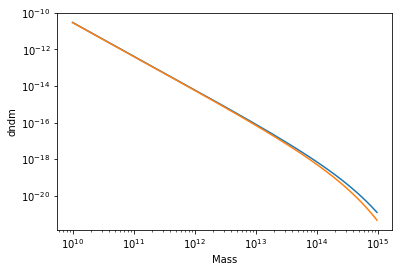

In [18]:
mf = MassFunction(hmf_model=MyNewFit, transfer_model='EH')
plt.plot(mf.m, mf.dndm)

mf.hmf_model = PS
plt.plot(mf.m, mf.dndm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass")
plt.ylabel("dndm")

It's clear that our new function doesn't drop off at high masses quite so fast.

## Parameterizing Custom Models

Imagine that we doubt that the cutoff should be proportional to $0.5 \nu^2$, and want to parameterize it as $a \nu^2$, and fit that free parameter $a$ to our simulated data. Any `Component` may be parameterized by writing a `_defaults` dictionary:

In [20]:
class MyNewFitParameterized(FittingFunction):
    _defaults = {'a': 0.5}
    
    @property
    def fsigma(self):
        return np.sqrt(2.0 / np.pi) * self.nu * np.exp(-self.params['a'] * self.nu2)

Notice that to access the actual user-supplied value of $a$, we use the `self.params` dictionary. The `_defaults` dictionary only specifies the default values.

Constructing a model, we can use the `hmf_params` to set $a$:

In [24]:
mf = MassFunction(hmf_model=MyNewFitParameterized, hmf_params={'a':0.55}, transfer_model='EH')

Text(0, 0.5, 'dndm')

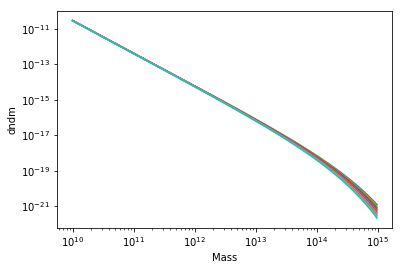

In [25]:
for a in np.arange(0.4,0.6,0.02):
    mf.hmf_params = {'a':a}
    
    plt.plot(mf.m, mf.dndm)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Mass")
plt.ylabel("dndm")

## Your Custom Model is a Plugin

Due to the generic way that the plugin architecture is implemented, your custom models also appear as plugins:

In [26]:
FittingFunction.get_models()

{'PS': hmf.mass_function.fitting_functions.PS,
 'SMT': hmf.mass_function.fitting_functions.SMT,
 'ST': hmf.mass_function.fitting_functions.ST,
 'Jenkins': hmf.mass_function.fitting_functions.Jenkins,
 'Warren': hmf.mass_function.fitting_functions.Warren,
 'Reed03': hmf.mass_function.fitting_functions.Reed03,
 'Reed07': hmf.mass_function.fitting_functions.Reed07,
 'Peacock': hmf.mass_function.fitting_functions.Peacock,
 'Angulo': hmf.mass_function.fitting_functions.Angulo,
 'AnguloBound': hmf.mass_function.fitting_functions.AnguloBound,
 'Watson_FoF': hmf.mass_function.fitting_functions.Watson_FoF,
 'Watson': hmf.mass_function.fitting_functions.Watson,
 'Crocce': hmf.mass_function.fitting_functions.Crocce,
 'Courtin': hmf.mass_function.fitting_functions.Courtin,
 'Bhattacharya': hmf.mass_function.fitting_functions.Bhattacharya,
 'Tinker08': hmf.mass_function.fitting_functions.Tinker08,
 'Tinker10': hmf.mass_function.fitting_functions.Tinker10,
 'Behroozi': hmf.mass_function.fitting_func

This means we can construct the `Framework` using string names of the models:

In [27]:
mf = MassFunction(hmf_model = 'MyNewFit')

In [28]:
mf.hmf_model

__main__.MyNewFit

This is particularly useful for dynamically creating frameworks from a library of custom classes, or specifying models in YAML/TOML configuration files.